In [1]:
!pip install rouge-score

In [11]:
from rouge_score import rouge_scorer
from rouge_score import scoring
import sys
sys.path.append('/Users/skylerroh/mids/tldr-reddit-summarization')
from preprocess import utils
import sentencepiece as spm
import numpy as np

In [4]:
CONTENT_KEY = 'inputs'
SUMMARY_KEY = 'targets'

In [5]:
sp = spm.SentencePieceProcessor(model_file="../../pegasus/ckpt/pegasus_ckpt/c4.unigram.newline.10pct.96000.model")

In [6]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL", "rougeLsum"], use_stemmer=True)

In [7]:
def encodeSPTokens(example):
    return sp.encode(example)

def decodeStartingTokens(tokens, n):
    return sp.decode(tokens[:n])

def decodeEndTokens(tokens, n):
    if len(tokens) >= n:
        return sp.decode(tokens[(len(tokens)-n):])
    else:
        return sp.decode(tokens)

def decodeBookendTokens(tokens, n):
    if len(tokens) >= n:
        return decodeStartingTokens(tokens, n//2) + " " + decodeEndTokens(tokens, n//2)
    else:
        return sp.decode(tokens)

In [17]:
def evaluateBaselines(example, max_tokens, scorer, verbose=False):
    tokens = encodeSPTokens(example[CONTENT_KEY].numpy())
    start = decodeStartingTokens(tokens, max_tokens)
    end = decodeEndTokens(tokens, max_tokens)
    bookend = decodeBookendTokens(tokens, max_tokens)
    summary = example[SUMMARY_KEY].numpy()
    
    if verbose:
        print(f'starting {max_tokens} tokens: {start}\n')
        print(f'ending {max_tokens} tokens: {end}\n')
        print(f'bookend {max_tokens} tokens: {bookend}\n')
        print(f'reference summary: {summary}\n')
    
    scores = {
        'start': scorer.score(start, summary),
        'end': scorer.score(end, summary),
        'bookend': scorer.score(bookend, summary)
    }
    summary_length = len(encodeSPTokens(summary))
    content_length = len(tokens)
    return (scores, content_length, summary_length)

In [18]:
def getMidRecallScores(aggregate_scores):
    return {r: scores.mid.recall for r, scores in aggregate_scores.items()}

def getMidF1Scores(aggregate_scores):
    return {r: scores.mid.fmeasure for r, scores in aggregate_scores.items()}

def getMidPrecisionScores(aggregate_scores):
    return {r: scores.mid.precision for r, scores in aggregate_scores.items()}

In [28]:
full_aggregate_scores = {
        'start': scoring.BootstrapAggregator(),
        'end': scoring.BootstrapAggregator(),
        'bookend': scoring.BootstrapAggregator()
    }

subreddit_scores = {}
for i, subreddit in enumerate(utils.top50subreddits):
    print(i, "--", subreddit)
    key = 'eval'
    dataset = utils.build(f'../preprocess/subreddits_data/subreddit_{subreddit}_{key}.tfrecord', False)
    
    aggregate_scores = {
        'start': scoring.BootstrapAggregator(),
        'end': scoring.BootstrapAggregator(),
        'bookend': scoring.BootstrapAggregator()
    }
    content_lengths = []
    summary_lengths = []
    
    for i, example in enumerate(dataset.take(1000)):
        example_score, content_len, summary_len = evaluateBaselines(example, 128, scorer, verbose=(i==0))
        for key, score in example_score.items():
            aggregate_scores[key].add_scores(score)
            full_aggregate_scores[key].add_scores(score)
        content_lengths.append(content_len)
        summary_lengths.append(summary_len)
        
    if content_lengths:
        agg_scores = {k: v.aggregate() for k, v in aggregate_scores.items()}
        score_summary = {k: {'recall': getMidRecallScores(agg),
                             'precision': getMidPrecisionScores(agg),
                             'f1': getMidF1Scores(agg)}
                         for k, agg in agg_scores.items()}
        score_summary['avg_content_len'] = float(sum(content_lengths)) / len(content_lengths)
        score_summary['avg_summary_len'] = float(sum(summary_lengths)) / len(summary_lengths)
        print(score_summary)
        subreddit_scores[subreddit] = score_summary
    print('************\n')
    
full_aggregated = {k: v.aggregate() for k, v in full_aggregate_scores.items()}
full_score_summary = {k: {'recall': getMidRecallScores(agg),
                         'precision': getMidPrecisionScores(agg),
                         'f1': getMidF1Scores(agg)}
                     for k, agg in full_aggregated.items()}
full_score_summary['avg_content_len'] = float(sum(content_lengths)) / len(content_lengths)
full_score_summary['avg_summary_len'] = float(sum(summary_lengths)) / len(summary_lengths)

0 -- AskReddit
starting 128 tokens: What is something you did as a kid that was normal at the time, but now you wonder what the fuck you were thinking? in ask reddit. I took rock fights to an extreme. My friends property had a hilly area that was basically a giant V shaped valley. It was steeper than a 45 degree angle and probably about 10-15 meters long. One of us would go to the top with a bunch of rocks (or unearth rocks at the top) and roll them down. The other other would be a meter or two from the bottom with an ice chest... and try to catch the rocks. Not just small rocks either. Rocks bigger

ending 128 tokens: that was basically a giant V shaped valley. It was steeper than a 45 degree angle and probably about 10-15 meters long. One of us would go to the top with a bunch of rocks (or unearth rocks at the top) and roll them down. The other other would be a meter or two from the bottom with an ice chest... and try to catch the rocks. Not just small rocks either. Rocks bigger than

{'start': {'recall': {'rouge1': 0.12498470980704701, 'rouge2': 0.029039744140161902, 'rougeL': 0.07813989841248631, 'rougeLsum': 0.08332337248056218}, 'precision': {'rouge1': 0.49537868379130934, 'rouge2': 0.13866471875430753, 'rougeL': 0.35259064983535926, 'rougeLsum': 0.3612080351173416}, 'f1': {'rouge1': 0.17873616309816887, 'rouge2': 0.04354372697320816, 'rougeL': 0.11586772197062778, 'rougeLsum': 0.12146669079306839}}, 'end': {'recall': {'rouge1': 0.12592457403022025, 'rouge2': 0.029880365483892803, 'rougeL': 0.0771402650979086, 'rougeLsum': 0.08229703535529956}, 'precision': {'rouge1': 0.5018963084682047, 'rouge2': 0.1376220700939617, 'rougeL': 0.3479809473512167, 'rougeLsum': 0.3574618750761146}, 'f1': {'rouge1': 0.18126228416221674, 'rouge2': 0.04477055575123766, 'rougeL': 0.11495267756215469, 'rougeLsum': 0.12082875345368974}}, 'bookend': {'recall': {'rouge1': 0.13021625315161783, 'rouge2': 0.032252425489355654, 'rougeL': 0.08167657533261535, 'rougeLsum': 0.08689717159606661},

{'start': {'recall': {'rouge1': 0.10129735958847264, 'rouge2': 0.024065011720254638, 'rougeL': 0.06657586880261802, 'rougeLsum': 0.06900606303222255}, 'precision': {'rouge1': 0.4940846159992959, 'rouge2': 0.1314056446768032, 'rougeL': 0.35367025169816063, 'rougeLsum': 0.3603212156830491}, 'f1': {'rouge1': 0.15681125555979858, 'rouge2': 0.0380457407486581, 'rougeL': 0.10495323365206577, 'rougeLsum': 0.10820700787305872}}, 'end': {'recall': {'rouge1': 0.10333471110268791, 'rouge2': 0.024509492127906266, 'rougeL': 0.06708962447887944, 'rougeLsum': 0.06992214056576698}, 'precision': {'rouge1': 0.4963234734706069, 'rouge2': 0.1273092340449019, 'rougeL': 0.35237238125640646, 'rougeLsum': 0.3587748790422328}, 'f1': {'rouge1': 0.1597920450890863, 'rouge2': 0.03840671266944772, 'rougeL': 0.10574813523671857, 'rougeLsum': 0.10930902296291214}}, 'bookend': {'recall': {'rouge1': 0.10703102397773853, 'rouge2': 0.026739877619215258, 'rougeL': 0.07077245710947397, 'rougeLsum': 0.07347778050469213}, '

{'start': {'recall': {'rouge1': 0.10266213537241575, 'rouge2': 0.009819021948402002, 'rougeL': 0.06301331067686208, 'rougeLsum': 0.0583404134806004}, 'precision': {'rouge1': 0.5113636363636364, 'rouge2': 0.05708245243128964, 'rougeL': 0.35984848484848486, 'rougeLsum': 0.3181818181818182}, 'f1': {'rouge1': 0.15954633601692425, 'rouge2': 0.01563920712856883, 'rougeL': 0.10078157136980666, 'rougeLsum': 0.09237821002526886}}, 'end': {'recall': {'rouge1': 0.16843910806174955, 'rouge2': 0.04744429882044561, 'rougeL': 0.09819897084048027, 'rougeLsum': 0.09819897084048027}, 'precision': {'rouge1': 0.6515151515151515, 'rouge2': 0.15010570824524314, 'rougeL': 0.39015151515151514, 'rougeLsum': 0.39015151515151514}, 'f1': {'rouge1': 0.2522404371584699, 'rouge2': 0.06914414414414415, 'rougeL': 0.14765027322404373, 'rougeLsum': 0.14765027322404373}}, 'bookend': {'recall': {'rouge1': 0.12398142469114168, 'rouge2': 0.009464285714285713, 'rougeL': 0.06562691667396828, 'rougeLsum': 0.06120213791290634},

{'start': {'recall': {'rouge1': 0.10036028325696576, 'rouge2': 0.03620931537598204, 'rougeL': 0.07637223256428637, 'rougeLsum': 0.07637223256428637}, 'precision': {'rouge1': 0.6327485380116958, 'rouge2': 0.22222222222222224, 'rougeL': 0.49274739135420254, 'rougeLsum': 0.4919409089171731}, 'f1': {'rouge1': 0.17025174239250487, 'rouge2': 0.06178548838890394, 'rougeL': 0.1306444557333559, 'rougeLsum': 0.1302355587904453}}, 'end': {'recall': {'rouge1': 0.07856199269977532, 'rouge2': 0.009779211614074001, 'rougeL': 0.05597956446488452, 'rougeLsum': 0.05586848791940325}, 'precision': {'rouge1': 0.5101096969002026, 'rouge2': 0.07469729344729344, 'rougeL': 0.3806960210984978, 'rougeLsum': 0.37926843251920656}, 'f1': {'rouge1': 0.13453891783634933, 'rouge2': 0.0171358024691358, 'rougeL': 0.09650201122935954, 'rougeLsum': 0.096413334037543}}, 'bookend': {'recall': {'rouge1': 0.09395159451276623, 'rouge2': 0.025961559546171315, 'rougeL': 0.07183907230056982, 'rougeLsum': 0.07187666175414965}, 'pr

{'start': {'recall': {'rouge1': 0.10629946571092394, 'rouge2': 0.02671786688134055, 'rougeL': 0.06905612138923385, 'rougeLsum': 0.07121815945386151}, 'precision': {'rouge1': 0.5144937673964004, 'rouge2': 0.15006429891121575, 'rougeL': 0.3673673174097343, 'rougeLsum': 0.3720803125392659}, 'f1': {'rouge1': 0.16472836736625196, 'rouge2': 0.042307152981372415, 'rougeL': 0.10876987270435491, 'rougeLsum': 0.1118744211550493}}, 'end': {'recall': {'rouge1': 0.10803061382314069, 'rouge2': 0.028785637592669416, 'rougeL': 0.06981353621396341, 'rougeLsum': 0.07209816826695097}, 'precision': {'rouge1': 0.5071413066120023, 'rouge2': 0.14615054991826237, 'rougeL': 0.3630576906208286, 'rougeLsum': 0.36844182334127507}, 'f1': {'rouge1': 0.16762902456855253, 'rouge2': 0.04518572446538545, 'rougeL': 0.11032025825757436, 'rougeLsum': 0.11345063046438963}}, 'bookend': {'recall': {'rouge1': 0.11143126358786729, 'rouge2': 0.030463641399892653, 'rougeL': 0.07329660875771661, 'rougeLsum': 0.07500376493202268},

{'start': {'recall': {'rouge1': 0.14554406925246105, 'rouge2': 0.031022603160978622, 'rougeL': 0.08607755135162537, 'rougeLsum': 0.09536839627078167}, 'precision': {'rouge1': 0.42579956006973374, 'rouge2': 0.10289177101444408, 'rougeL': 0.2914499621036085, 'rougeLsum': 0.3021088867133289}, 'f1': {'rouge1': 0.18473517461312733, 'rouge2': 0.04097113312554891, 'rougeL': 0.11459620142412903, 'rougeLsum': 0.12263035701346212}}, 'end': {'recall': {'rouge1': 0.1393217813924645, 'rouge2': 0.02610992916855827, 'rougeL': 0.08062725967492984, 'rougeLsum': 0.09009886148792162}, 'precision': {'rouge1': 0.41294327017051435, 'rouge2': 0.08514890896791491, 'rougeL': 0.2756988084005282, 'rougeLsum': 0.2870294618167527}, 'f1': {'rouge1': 0.1766466978400288, 'rouge2': 0.0342286722698827, 'rougeL': 0.10678450278329171, 'rougeLsum': 0.11591086925949975}}, 'bookend': {'recall': {'rouge1': 0.14943310758844064, 'rouge2': 0.03244765429977056, 'rougeL': 0.08872502101180349, 'rougeLsum': 0.09895450872034131}, 'p

{'start': {'recall': {'rouge1': 0.19387755102040816, 'rouge2': 0.020618556701030927, 'rougeL': 0.12244897959183673, 'rougeLsum': 0.1326530612244898}, 'precision': {'rouge1': 0.5, 'rouge2': 0.05405405405405406, 'rougeL': 0.3157894736842105, 'rougeLsum': 0.34210526315789475}, 'f1': {'rouge1': 0.27941176470588236, 'rouge2': 0.02985074626865672, 'rougeL': 0.1764705882352941, 'rougeLsum': 0.1911764705882353}}, 'end': {'recall': {'rouge1': 0.13861386138613863, 'rouge2': 0.03, 'rougeL': 0.04950495049504951, 'rougeLsum': 0.09900990099009901}, 'precision': {'rouge1': 0.3684210526315789, 'rouge2': 0.08108108108108109, 'rougeL': 0.13157894736842105, 'rougeLsum': 0.2631578947368421}, 'f1': {'rouge1': 0.20143884892086333, 'rouge2': 0.0437956204379562, 'rougeL': 0.07194244604316546, 'rougeLsum': 0.14388489208633093}}, 'bookend': {'recall': {'rouge1': 0.1958762886597938, 'rouge2': 0.03125, 'rougeL': 0.1134020618556701, 'rougeLsum': 0.14432989690721648}, 'precision': {'rouge1': 0.5, 'rouge2': 0.081081

{'start': {'recall': {'rouge1': 0.1308438471399065, 'rouge2': 0.02989453164483457, 'rougeL': 0.07907298998373471, 'rougeLsum': 0.08255856829634534}, 'precision': {'rouge1': 0.4724566128445885, 'rouge2': 0.1266549939048715, 'rougeL': 0.325656323206056, 'rougeLsum': 0.33058289526261236}, 'f1': {'rouge1': 0.18432625955966653, 'rouge2': 0.04339433747995039, 'rougeL': 0.11507118541899145, 'rougeLsum': 0.11875202905406096}}, 'end': {'recall': {'rouge1': 0.13008133132544186, 'rouge2': 0.02685764080857188, 'rougeL': 0.0769224655737975, 'rougeLsum': 0.08009483061660255}, 'precision': {'rouge1': 0.4586346540191857, 'rouge2': 0.10284469835286436, 'rougeL': 0.3057316827831431, 'rougeLsum': 0.3105080142835822}, 'f1': {'rouge1': 0.18153451624667816, 'rouge2': 0.038106209309691885, 'rougeL': 0.1107909001115635, 'rougeLsum': 0.1140012866645432}}, 'bookend': {'recall': {'rouge1': 0.13675998655288357, 'rouge2': 0.03263109875820769, 'rougeL': 0.08408128796766125, 'rougeLsum': 0.08778361804299464}, 'preci

{'start': {'recall': {'rouge1': 0.15665480235507187, 'rouge2': 0.037627275604944665, 'rougeL': 0.09104443518704475, 'rougeLsum': 0.09732109595426522}, 'precision': {'rouge1': 0.4915952066771887, 'rouge2': 0.13486114402661714, 'rougeL': 0.31855594306736557, 'rougeLsum': 0.3261801078737932}, 'f1': {'rouge1': 0.21336186281956293, 'rouge2': 0.05351225189474905, 'rougeL': 0.12844266119751335, 'rougeLsum': 0.13461946285361398}}, 'end': {'recall': {'rouge1': 0.15547726775603676, 'rouge2': 0.03514152907118355, 'rougeL': 0.08929178464928554, 'rougeLsum': 0.09681123375427293}, 'precision': {'rouge1': 0.4866766444169479, 'rouge2': 0.11799382084376718, 'rougeL': 0.312580334158022, 'rougeLsum': 0.3217624049030232}, 'f1': {'rouge1': 0.21127060751468418, 'rouge2': 0.04901042297736577, 'rougeL': 0.1259260267467962, 'rougeLsum': 0.13338857926158454}}, 'bookend': {'recall': {'rouge1': 0.16347755249155385, 'rouge2': 0.041537800017717896, 'rougeL': 0.09616658544874425, 'rougeLsum': 0.10304714997888051}, '

{'start': {'recall': {'rouge1': 0.11506628253324988, 'rouge2': 0.022717267647817917, 'rougeL': 0.06944489821854843, 'rougeLsum': 0.07335419554552955}, 'precision': {'rouge1': 0.4440161375212459, 'rouge2': 0.09817099892981215, 'rougeL': 0.29861612842573715, 'rougeLsum': 0.3049536834357952}, 'f1': {'rouge1': 0.16503684087710335, 'rouge2': 0.03368331087259011, 'rougeL': 0.10253727719048071, 'rougeLsum': 0.1067770544048463}}, 'end': {'recall': {'rouge1': 0.11742281034086413, 'rouge2': 0.023318986700527896, 'rougeL': 0.07111534835457611, 'rougeLsum': 0.07450313505636003}, 'precision': {'rouge1': 0.4586436788045264, 'rouge2': 0.10166308647645263, 'rougeL': 0.3094682244055317, 'rougeLsum': 0.31498296330488745}, 'f1': {'rouge1': 0.16926126762488852, 'rouge2': 0.034566104536308956, 'rougeL': 0.10544685151785482, 'rougeLsum': 0.10927660714310306}}, 'bookend': {'recall': {'rouge1': 0.1219563197012628, 'rouge2': 0.025715172178986515, 'rougeL': 0.07438419029905896, 'rougeLsum': 0.07859737952351281}

{'start': {'recall': {'rouge1': 0.11133555500308524, 'rouge2': 0.030507474226533514, 'rougeL': 0.07500404791629128, 'rougeLsum': 0.07657967622610594}, 'precision': {'rouge1': 0.5261084934782667, 'rouge2': 0.15003640372286264, 'rougeL': 0.38385612597307933, 'rougeLsum': 0.3865107284758622}, 'f1': {'rouge1': 0.17255479650902494, 'rouge2': 0.04779572121471996, 'rougeL': 0.11823072705013432, 'rougeLsum': 0.12058104769984504}}, 'end': {'recall': {'rouge1': 0.1112978607902857, 'rouge2': 0.02735597446132863, 'rougeL': 0.07172615814817965, 'rougeLsum': 0.07391699315986572}, 'precision': {'rouge1': 0.5167621335350032, 'rouge2': 0.12455403161877428, 'rougeL': 0.3650814205394082, 'rougeLsum': 0.36857680100599116}, 'f1': {'rouge1': 0.171779523293018, 'rouge2': 0.042394616156615564, 'rougeL': 0.11283443129602594, 'rougeLsum': 0.11567717429078642}}, 'bookend': {'recall': {'rouge1': 0.1164658186206518, 'rouge2': 0.032275637308957196, 'rougeL': 0.07827139900230876, 'rougeLsum': 0.08003796550492959}, '

{'start': {'recall': {'rouge1': 0.07547854366798512, 'rouge2': 0.009343672140452744, 'rougeL': 0.04701016774822281, 'rougeLsum': 0.05031137905349793}, 'precision': {'rouge1': 0.3599686721528213, 'rouge2': 0.051003997791194244, 'rougeL': 0.2538853993387993, 'rougeLsum': 0.259402270410821}, 'f1': {'rouge1': 0.11223893115618097, 'rouge2': 0.014222319997253898, 'rougeL': 0.07253973799344571, 'rougeLsum': 0.07602557838152521}}, 'end': {'recall': {'rouge1': 0.08138602723854657, 'rouge2': 0.012672998160271067, 'rougeL': 0.05102817968429381, 'rougeLsum': 0.05495555754006977}, 'precision': {'rouge1': 0.38588340306196633, 'rouge2': 0.06527857452844828, 'rougeL': 0.2698738965737413, 'rougeLsum': 0.27712405425693104}, 'f1': {'rouge1': 0.12132259243857862, 'rouge2': 0.019561864373092666, 'rougeL': 0.07863194251629535, 'rougeLsum': 0.08289133090683014}}, 'bookend': {'recall': {'rouge1': 0.08172050388075436, 'rouge2': 0.012113157465834162, 'rougeL': 0.0510583390175189, 'rougeLsum': 0.0548149179578952

{'start': {'recall': {'rouge1': 0.12623914395205998, 'rouge2': 0.026865834509568608, 'rougeL': 0.07723919628279816, 'rougeLsum': 0.08225894626921501}, 'precision': {'rouge1': 0.48049650320391013, 'rouge2': 0.13052577093334977, 'rougeL': 0.33607877762622, 'rougeLsum': 0.34331046111476093}, 'f1': {'rouge1': 0.1799140544138333, 'rouge2': 0.04064202118745486, 'rougeL': 0.11402504805981412, 'rougeLsum': 0.11928848436451875}}, 'end': {'recall': {'rouge1': 0.12840213903603523, 'rouge2': 0.028957264143726007, 'rougeL': 0.07775151149527973, 'rougeLsum': 0.08263527177193605}, 'precision': {'rouge1': 0.484112047219861, 'rouge2': 0.1265184664870268, 'rougeL': 0.3320228531281266, 'rougeLsum': 0.34072059549917183}, 'f1': {'rouge1': 0.1825888140049689, 'rouge2': 0.042830539071184406, 'rougeL': 0.1142987800427919, 'rougeLsum': 0.12008236039080539}}, 'bookend': {'recall': {'rouge1': 0.13253938154121125, 'rouge2': 0.0304635546491916, 'rougeL': 0.08180001712576751, 'rougeLsum': 0.08667061716700783}, 'pre

{'start': {'recall': {'rouge1': 0.13467720549091733, 'rouge2': 0.033223387677430175, 'rougeL': 0.08287246378967394, 'rougeLsum': 0.08904959214554761}, 'precision': {'rouge1': 0.521849545949383, 'rouge2': 0.15230100117958334, 'rougeL': 0.36333556481449847, 'rougeLsum': 0.37362731189646115}, 'f1': {'rouge1': 0.1918663339625847, 'rouge2': 0.04943141572818226, 'rougeL': 0.12209046487068348, 'rougeLsum': 0.12911889152836376}}, 'end': {'recall': {'rouge1': 0.1317916429898869, 'rouge2': 0.0328622160444134, 'rougeL': 0.08039118812394541, 'rougeLsum': 0.08656560556928751}, 'precision': {'rouge1': 0.5171796556467732, 'rouge2': 0.14224506513483803, 'rougeL': 0.35439485738150134, 'rougeLsum': 0.3639566136532637}, 'f1': {'rouge1': 0.1887815520595375, 'rouge2': 0.04839173635837264, 'rougeL': 0.11914743325647731, 'rougeLsum': 0.12614920406522395}}, 'bookend': {'recall': {'rouge1': 0.13643967649204625, 'rouge2': 0.03428642307842737, 'rougeL': 0.08487604148673092, 'rougeLsum': 0.09113630281706449}, 'pr

{'start': {'recall': {'rouge1': 0.12237081459740998, 'rouge2': 0.027488298395412072, 'rougeL': 0.07474164562470445, 'rougeLsum': 0.07822121014970704}, 'precision': {'rouge1': 0.4672928948113339, 'rouge2': 0.11897877996454445, 'rougeL': 0.32300739507358067, 'rougeLsum': 0.32826967792673045}, 'f1': {'rouge1': 0.17519048005226295, 'rouge2': 0.04053357909043903, 'rougeL': 0.11040457756325725, 'rougeLsum': 0.11418848705298024}}, 'end': {'recall': {'rouge1': 0.12316156884154121, 'rouge2': 0.02546966038561882, 'rougeL': 0.07350944445193774, 'rougeLsum': 0.07693029655580605}, 'precision': {'rouge1': 0.46638985832963237, 'rouge2': 0.10168796330721513, 'rougeL': 0.312523191409728, 'rougeLsum': 0.3178028338197536}, 'f1': {'rouge1': 0.17596573401076906, 'rouge2': 0.03699538007222261, 'rougeL': 0.10813350306492643, 'rougeLsum': 0.11178610769392638}}, 'bookend': {'recall': {'rouge1': 0.1302661980143553, 'rouge2': 0.03113819728444775, 'rougeL': 0.07970218596017614, 'rougeLsum': 0.08353721024574429}, 

{'start': {'recall': {'rouge1': 0.1344593737366575, 'rouge2': 0.03339379149970362, 'rougeL': 0.08102503219134455, 'rougeLsum': 0.08630263044695312}, 'precision': {'rouge1': 0.5074595401334154, 'rouge2': 0.14082988817562647, 'rougeL': 0.3468028780610799, 'rougeLsum': 0.3562839503300306}, 'f1': {'rouge1': 0.1914368263259199, 'rouge2': 0.049209134944565316, 'rougeL': 0.1189859068165697, 'rougeLsum': 0.12527739206961563}}, 'end': {'recall': {'rouge1': 0.13864669645657135, 'rouge2': 0.033012716000409635, 'rougeL': 0.08175431510134334, 'rougeLsum': 0.08729820712657085}, 'precision': {'rouge1': 0.5083573506204115, 'rouge2': 0.12841854528075092, 'rougeL': 0.33747961048504815, 'rougeLsum': 0.34738845861235756}, 'f1': {'rouge1': 0.19606331349406206, 'rouge2': 0.0474618890978938, 'rougeL': 0.11923663747040592, 'rougeLsum': 0.12582148101058022}}, 'bookend': {'recall': {'rouge1': 0.14321620037754412, 'rouge2': 0.037825120282868684, 'rougeL': 0.08744765311500242, 'rougeLsum': 0.09302678404951328}, '

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

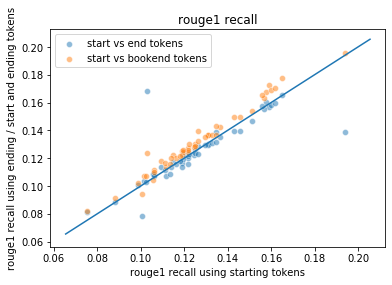

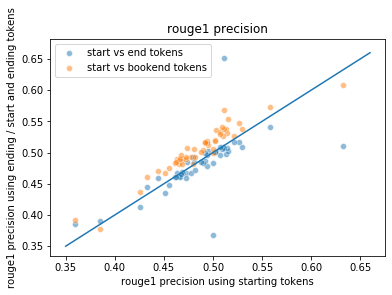

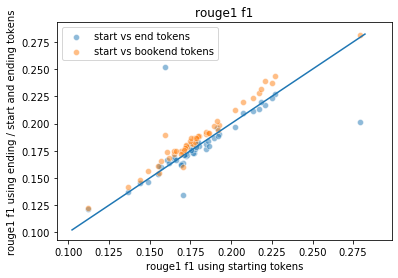

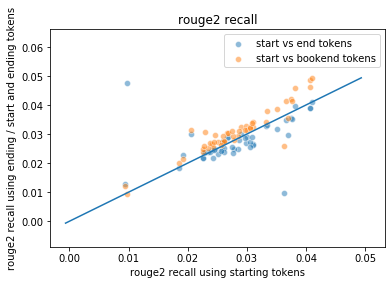

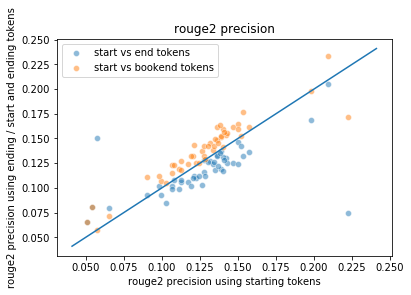

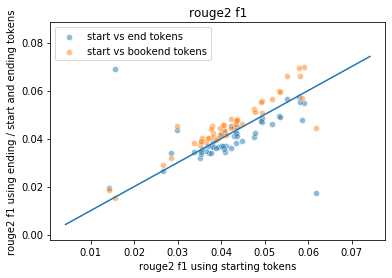

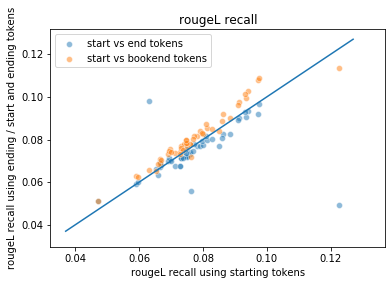

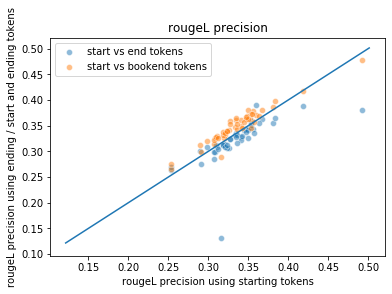

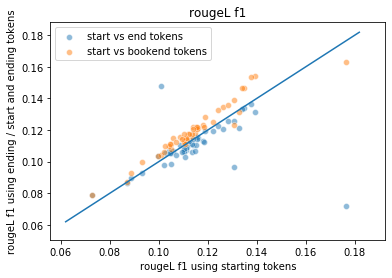

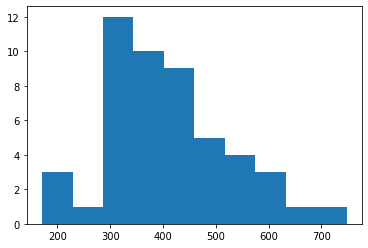

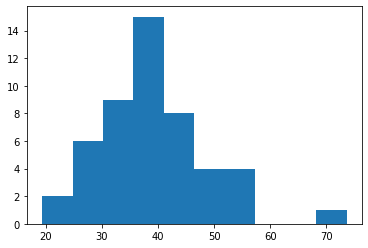

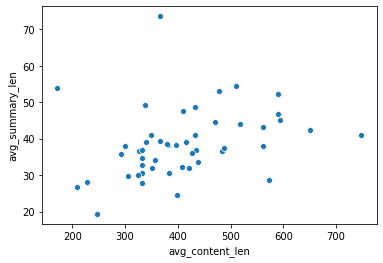

In [44]:
for r in ['rouge1', 'rouge2', 'rougeL']:
    for m in ['recall', 'precision', 'f1']:
        
        s = [score['start'][m][r] for sr, score in subreddit_scores.items()]
        e = [score['end'][m][r] for sr, score in subreddit_scores.items()]
        be = [score['bookend'][m][r] for sr, score in subreddit_scores.items()]
        sns.scatterplot(x=s, y=e, label='start vs end tokens', alpha=0.5)
        sns.scatterplot(x=s, y=be, label='start vs bookend tokens', alpha=0.5)
        
        plt.xlabel(f'{r} {m} using starting tokens')
        plt.ylabel(f'{r} {m} using ending / start and ending tokens')
        identity = np.arange(min(min(s), min(e), min(be)) - 0.01, max(max(s), max(e), max(be)) + 0.01, 0.01)
        sns.lineplot(x=identity, y=identity)
        plt.title(f'{r} {m}')
        plt.legend()
        plt.show()
        
plt.hist([score['avg_content_len'] for sr, score in subreddit_scores.items()])
plt.show()
plt.hist([score['avg_summary_len'] for sr, score in subreddit_scores.items()])
plt.show()

fig = sns.scatterplot([score['avg_content_len'] for sr, score in subreddit_scores.items()],
                [score['avg_summary_len'] for sr, score in subreddit_scores.items()])
fig.set_xlabel('avg_content_len')
fig.set_ylabel('avg_summary_len')
plt.show()


In [45]:
[(sr, score) for sr, score in subreddit_scores.items() if score['bookend']['f1']['rouge2']>0.06]



[('relationships',
  {'start': {'recall': {'rouge1': 0.15891245796564946,
     'rouge2': 0.040736914752472875,
     'rougeL': 0.09726110967816358,
     'rougeLsum': 0.09987629100407093},
    'precision': {'rouge1': 0.5150650192640989,
     'rouge2': 0.15335246491220317,
     'rougeL': 0.34944651506398006,
     'rougeLsum': 0.35193822469618996},
    'f1': {'rouge1': 0.22070314281099943,
     'rouge2': 0.05903603801203534,
     'rougeL': 0.13946860428449637,
     'rougeLsum': 0.14188674346567098}},
   'end': {'recall': {'rouge1': 0.1570012369967378,
     'rouge2': 0.0388609588122172,
     'rougeL': 0.09204942910960742,
     'rougeLsum': 0.09523879708318256},
    'precision': {'rouge1': 0.5027732483409086,
     'rouge2': 0.13258886758231692,
     'rougeL': 0.32519128865702046,
     'rougeLsum': 0.3285668773720408},
    'f1': {'rouge1': 0.2171938169076476,
     'rouge2': 0.05495611826802184,
     'rougeL': 0.13141372282392205,
     'rougeLsum': 0.13421191318031572}},
   'bookend': {'recall

ROUGE f1 scores for full eval dataset on basic k token extraction

In [34]:
{key: score_summary['f1'] for key, score_summary in full_score_summary.items() if key in ('start', 'end', 'bookend')}

{'start': {'rouge1': 0.18206664082981033,
  'rouge2': 0.043282998515120144,
  'rougeL': 0.11467040996698588,
  'rougeLsum': 0.11931789120670529},
 'end': {'rouge1': 0.18175715488067468,
  'rouge2': 0.041296977287191346,
  'rougeL': 0.11274912652863349,
  'rougeLsum': 0.11763844226717263},
 'bookend': {'rouge1': 0.19104658299042832,
  'rouge2': 0.04794463775260151,
  'rougeL': 0.12136087395148525,
  'rougeLsum': 0.12650663756136388}}